In [1]:
# !pip install dask-ml

In [14]:
import os

os.environ["USE_PYGEOS"] = "0"

import datacube
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from odc.ui import DcViewer
from datacube.utils import masking
from datacube.utils.rio import configure_s3_access
from datacube.utils.cog import write_cog

from dask.distributed import Client, LocalCluster
from dea_tools.dask import create_local_dask_cluster

from dea_tools.datahandling import wofs_fuser
from dea_tools.plotting import plot_wo
from dea_tools.bandindices import calculate_indices

from IPython.display import Image
from IPython.core.display import Video

from dea_tools.plotting import display_map, rgb, xr_animation

import dask_ml
import spei as si  # si for standardized index
import scipy.stats as scs

import xgboost as xgb


# from sklearn.externals import joblib

In [15]:
print(si.__version__)

0.4.1


In [17]:
# cluster = LocalCluster()
# client = Client(cluster)

client = create_local_dask_cluster(return_client=True)
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

/env/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41663 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/grupo13/proxy/41663/status,
Dashboard: /user/grupo13/proxy/41663/status,Workers: 1
Total threads: 8,Total memory: 26.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46565,Workers: 1
Dashboard: /user/grupo13/proxy/41663/status,Total threads: 8
Started: Just now,Total memory: 26.21 GiB
Comm: tcp://127.0.0.1:41977,Total threads: 8
Dashboard: /user/grupo13/proxy/40203/status,Memory: 26.21 GiB
Nanny: tcp://127.0.0.1:40343,


In [18]:
dc = datacube.Datacube(app='ml-prediction-analysis-1') # https://opendatacube.readthedocs.io/en/latest/api/core-classes/datacube.html

In [19]:
dc.list_products()

,name,description,license,default_crs,default_resolution
name,,,,,
asf_s1_grd_gamma0,asf_s1_grd_gamma0,Sentinel 1 Radiometrically Terrain Corrected,CC-BY-4.0,None,None
asf_s1_rtc_grd_hd,asf_s1_rtc_grd_hd,Sentinel 1 Radiometrically Terrain Corrected,CC-BY-4.0,None,None
copernicus_dem_30,copernicus_dem_30,Copernicus 30m Digital Elevation Model (GLO-30),None,None,None
copernicus_dem_90,copernicus_dem_90,Copernicus 90m Digital Elevation Model (GLO-90),None,None,None
cr2met,cr2met,"CR2MET, a high-resolution precipitation and te...",None,None,None
fasat_charlie_ms,fasat_charlie_ms,FASat Charlie TOA multi-spectral data (Sistema...,None,None,None
landcover_chile_2014,landcover_chile_2014,Land Cover de Chile 2014,None,None,None
landsat5_c2l2_sr,landsat5_c2l2_sr,Landsat 5 Collection 2 Level-2 Surface Reflect...,None,None,None
landsat5_c2l2_st,landsat5_c2l2_st,Landsat 5 Collection 2 Level-2 UTM Surface Tem...,CC-BY-4.0,None,None


In [20]:
product = 'landsat7_c2l2_sr'

buffer = .1

petorca_coordinates = {
    "y": (-32.08, -32.35),
    "x": (-70.6, -71.09)
}

# Set the central latitude and longitude
central_lat = -32.2517
central_lon = -70.9233

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat + buffer, central_lat - buffer)
study_area_lon = (central_lon + buffer*1, central_lon - buffer*1)

query = {
    "product": product,
    # "measurements" : ["red", "nir08", "qa_pixel"],
    "y": study_area_lat, 
    "x": study_area_lon,
    "time": ("2012-01-01", "2024-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-30, 30),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

In [21]:
display_map(x=query['x'], y=query['y'])


In [22]:
ds = dc.load(**query)

In [23]:
ds

<xarray.Dataset>
Dimensions:        (time: 473, y: 751, x: 642)
Coordinates:
  * time           (time) datetime64[ns] 2012-01-03T14:33:28.296742 ... 2023-...
  * y              (y) float64 6.441e+06 6.441e+06 ... 6.419e+06 6.419e+06
  * x              (x) float64 3.092e+05 3.092e+05 ... 3.284e+05 3.284e+05
    spatial_ref    int32 32719
Data variables:
    blue           (time, y, x) uint16 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    green          (time, y, x) uint16 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    red            (time, y, x) uint16 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    nir08          (time, y, x) uint16 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    swir16         (time, y, x) uint16 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    swir22         (time, y, x) uint16 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    atmos_opacity  (time, y, x) int16 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    qa_pixel       (time, y, x) uint16 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    qa_radsat      (time, y, x) uint16 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    cloud_qa       (time, y, x) uint8 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

In [24]:
ds = ds.rename_vars({'nir08': 'nir'})

In [25]:
# Compute NDWI; `collection='ga_gm_3'` ensures the correct formula
# is applied to our Geomedian data
# ds = calculate_indices(ds, index="NDWI", collection="ga_gm_3")

In [26]:
# Crear una nueva coordenada "month_year" que sea una combinación de mes y año
ds['month_year'] = xr.DataArray(ds['time'].dt.strftime('%Y-%m'), coords=[ds.coords['time']], name='month_year')
# Agrupar por la nueva coordenada "month_year" y calcular la media
monthly_data = ds.groupby('month_year').mean('time').compute()

/env/lib/python3.10/site-packages/rasterio/warp.py:344: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


In [27]:
monthly_data['NVDI'] = (monthly_data['nir'] - monthly_data['red']) / (monthly_data['nir'] + monthly_data['red'])

In [28]:
product = 'cr2met'

buffer = .1

petorca_coordinates = {
    "y": (-32.08, -32.35),
    "x": (-70.6, -71.09)
}

# Set the central latitude and longitude
central_lat = -32.2517
central_lon = -70.9233

# Set the buffer to load around the central coordinates
buffer = 0.1

# Compute the bounding box for the study area
study_area_lat = (central_lat + buffer, central_lat - buffer)
study_area_lon = (central_lon + buffer*1, central_lon - buffer*1)

query = {
    "product": product,
    # "measurements" : ["red", "nir08", "qa_pixel"],
    "y": study_area_lat, 
    "x": study_area_lon,
    "time": ("2012-01-01", "2024-12-31"),
    "output_crs": "EPSG:32719",
    "resolution": (-30, 30),
    "dask_chunks": {"time": 1, 'x':2048, 'y':2048},
    "group_by": "solar_day"
}

In [29]:
cr2met = dc.load(**query)

In [30]:
ds['pr'] = cr2met.interp(time=ds.time).pr
ds['pr_sd'] = cr2met.interp(time=ds.time).pr_sd
ds['tmin'] = cr2met.interp(time=ds.time).tmin
ds['tmax'] = cr2met.interp(time=ds.time).tmax

In [31]:
ds['tmax']

<xarray.DataArray 'tmax' (time: 473, y: 751, x: 642)>
dask.array<transpose, shape=(473, 751, 642), dtype=float32, chunksize=(473, 751, 642), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2012-01-03T14:33:28.296742 ... 2023-05...
  * y            (y) float64 6.441e+06 6.441e+06 ... 6.419e+06 6.419e+06
  * x            (x) float64 3.092e+05 3.092e+05 ... 3.284e+05 3.284e+05
    spatial_ref  int32 32719
Attributes:
    units:         celcius
    nodata:        nan
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

In [32]:
cr2met

<xarray.Dataset>
Dimensions:      (time: 3653, y: 751, x: 642)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-01 2012-01-02 ... 2021-12-31
  * y            (y) float64 6.441e+06 6.441e+06 ... 6.419e+06 6.419e+06
  * x            (x) float64 3.092e+05 3.092e+05 ... 3.284e+05 3.284e+05
    spatial_ref  int32 32719
Data variables:
    pr           (time, y, x) float32 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    pr_sd        (time, y, x) float32 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    tmin         (time, y, x) float32 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
    tmax         (time, y, x) float32 dask.array<chunksize=(1, 751, 642), meta=np.ndarray>
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

In [33]:
# monthly_data = cr2met.groupby('time.month').mean('time')

In [34]:
# monthly_data_computed = monthly_data.compute()

In [35]:

# Crear una nueva coordenada "month_year" que sea una combinación de mes y año
cr2met['month_year'] = xr.DataArray(cr2met['time'].dt.strftime('%Y-%m'), coords=[cr2met.coords['time']], name='month_year')
# Agrupar por la nueva coordenada "month_year" y calcular la media
cr2met_monthly = cr2met.groupby('month_year').mean('time').compute()

monthly_data['pr'] = cr2met_monthly.pr
monthly_data['pr_std'] = cr2met_monthly.pr_sd
monthly_data['tmin'] = cr2met_monthly.tmin
monthly_data['tmax'] = cr2met_monthly.tmax

/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 13.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [36]:
monthly_data

<xarray.Dataset>
Dimensions:        (y: 751, x: 642, month_year: 137)
Coordinates:
  * y              (y) float64 6.441e+06 6.441e+06 ... 6.419e+06 6.419e+06
  * x              (x) float64 3.092e+05 3.092e+05 ... 3.284e+05 3.284e+05
  * month_year     (month_year) object '2012-01' '2012-02' ... '2023-05'
    spatial_ref    int32 32719
Data variables: (12/15)
    blue           (month_year, y, x) float64 4.46e+03 6.767e+03 ... 7.797e+03
    green          (month_year, y, x) float64 4.79e+03 7.16e+03 ... 7.637e+03
    red            (month_year, y, x) float64 5.108e+03 7.63e+03 ... 7.646e+03
    nir            (month_year, y, x) float64 5.754e+03 8.66e+03 ... 8.382e+03
    swir16         (month_year, y, x) float64 6.516e+03 9.679e+03 ... 7.977e+03
    swir22         (month_year, y, x) float64 5.908e+03 8.766e+03 ... 8.039e+03
    ...             ...
    cloud_qa       (month_year, y, x) float64 0.0 0.0 0.0 0.0 ... 32.0 32.0 32.0
    NVDI           (month_year, y, x) float64 0.05948 0.06318 ... 0.04592
    pr             (month_year, y, x) float32 0.0 0.0 0.0 0.0 ... nan nan nan
    pr_std         (month_year, y, x) float32 0.03032 0.03032 ... nan nan
    tmin           (month_year, y, x) float32 11.42 11.42 11.42 ... nan nan nan
    tmax           (month_year, y, x) float32 23.39 23.39 23.39 ... nan nan nan
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

## Defining the drough indices

In [37]:
monthly_data

<xarray.Dataset>
Dimensions:        (y: 751, x: 642, month_year: 137)
Coordinates:
  * y              (y) float64 6.441e+06 6.441e+06 ... 6.419e+06 6.419e+06
  * x              (x) float64 3.092e+05 3.092e+05 ... 3.284e+05 3.284e+05
  * month_year     (month_year) object '2012-01' '2012-02' ... '2023-05'
    spatial_ref    int32 32719
Data variables: (12/15)
    blue           (month_year, y, x) float64 4.46e+03 6.767e+03 ... 7.797e+03
    green          (month_year, y, x) float64 4.79e+03 7.16e+03 ... 7.637e+03
    red            (month_year, y, x) float64 5.108e+03 7.63e+03 ... 7.646e+03
    nir            (month_year, y, x) float64 5.754e+03 8.66e+03 ... 8.382e+03
    swir16         (month_year, y, x) float64 6.516e+03 9.679e+03 ... 7.977e+03
    swir22         (month_year, y, x) float64 5.908e+03 8.766e+03 ... 8.039e+03
    ...             ...
    cloud_qa       (month_year, y, x) float64 0.0 0.0 0.0 0.0 ... 32.0 32.0 32.0
    NVDI           (month_year, y, x) float64 0.05948 0.06318 ... 0.04592
    pr             (month_year, y, x) float32 0.0 0.0 0.0 0.0 ... nan nan nan
    pr_std         (month_year, y, x) float32 0.03032 0.03032 ... nan nan
    tmin           (month_year, y, x) float32 11.42 11.42 11.42 ... nan nan nan
    tmax           (month_year, y, x) float32 23.39 23.39 23.39 ... nan nan nan
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

In [38]:
media = monthly_data.pr.mean(dim='month_year')
desviacion = monthly_data.pr.std(dim='month_year')
spei = (monthly_data.pr - media) / desviacion

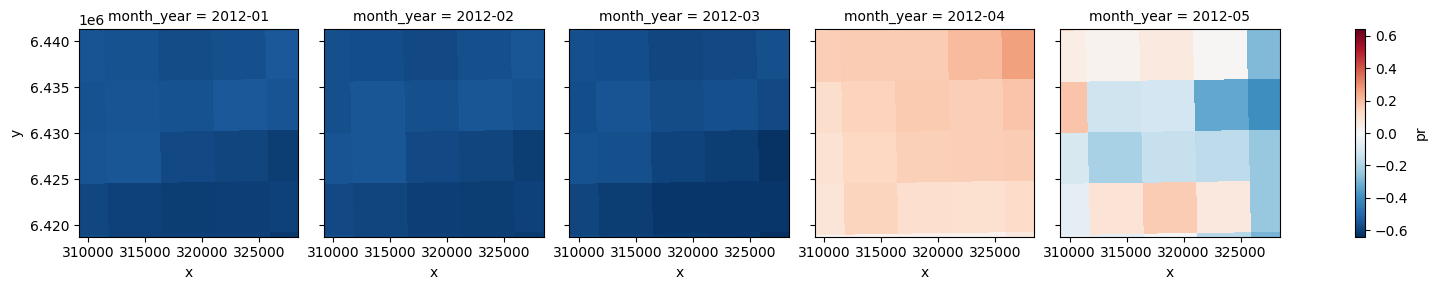

In [39]:
spei.isel(month_year = [0,1,2,3,4]).plot(col = 'month_year')

In [40]:
monthly_data['spei'] = spei
monthly_data['spei_shifted'] = monthly_data.spei.shift(month_year=-3)

In [41]:
monthly_data

<xarray.Dataset>
Dimensions:        (y: 751, x: 642, month_year: 137)
Coordinates:
  * y              (y) float64 6.441e+06 6.441e+06 ... 6.419e+06 6.419e+06
  * x              (x) float64 3.092e+05 3.092e+05 ... 3.284e+05 3.284e+05
  * month_year     (month_year) object '2012-01' '2012-02' ... '2023-05'
    spatial_ref    int32 32719
Data variables: (12/17)
    blue           (month_year, y, x) float64 4.46e+03 6.767e+03 ... 7.797e+03
    green          (month_year, y, x) float64 4.79e+03 7.16e+03 ... 7.637e+03
    red            (month_year, y, x) float64 5.108e+03 7.63e+03 ... 7.646e+03
    nir            (month_year, y, x) float64 5.754e+03 8.66e+03 ... 8.382e+03
    swir16         (month_year, y, x) float64 6.516e+03 9.679e+03 ... 7.977e+03
    swir22         (month_year, y, x) float64 5.908e+03 8.766e+03 ... 8.039e+03
    ...             ...
    pr             (month_year, y, x) float32 0.0 0.0 0.0 0.0 ... nan nan nan
    pr_std         (month_year, y, x) float32 0.03032 0.03032 ... nan nan
    tmin           (month_year, y, x) float32 11.42 11.42 11.42 ... nan nan nan
    tmax           (month_year, y, x) float32 23.39 23.39 23.39 ... nan nan nan
    spei           (month_year, y, x) float32 -0.5484 -0.5484 ... nan nan
    spei_shifted   (month_year, y, x) float32 0.1336 0.1336 0.1336 ... nan nan
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

In [42]:
def classify_spei(spei_values, multiclass=False):
    if multiclass == False:
         # Inicializa el resultado con el valor más bajo de clasificación
        spei_classification = np.full(spei_values.shape, 6, dtype=int)

        # Aplica las condiciones de forma vectorizada
        spei_classification = np.where(spei_values <= -2, 0, spei_classification)
        spei_classification = np.where((-2 < spei_values) & (spei_values <= -1.5), 1, spei_classification)
        spei_classification = np.where((-1.5 < spei_values) & (spei_values <= -1.0), 2, spei_classification)
        spei_classification = np.where((-1.0 < spei_values) & (spei_values <= 1.0), 3, spei_classification)
        spei_classification = np.where((1.0 < spei_values) & (spei_values <= 1.5), 4, spei_classification)
        spei_classification = np.where((1.5 < spei_values) & (spei_values < 2.0), 5, spei_classification)
    else:
        # Inicializa el resultado con el valor más bajo de clasificación
        # Partimos determinando que todos los puntos tienen clasificación de "no drought" 
        spei_classification = np.full(spei_values.shape, 0, dtype=int)

        # Aplica las condiciones de forma vectorizada
        # Si se cumple la condición, entonces se le asigna el valor de 1 o "drought"
        spei_classification = np.where(spei_values <= -1, 1, spei_classification)
    
    return spei_classification
    
monthly_data['spei_classification'] = xr.apply_ufunc(classify_spei, monthly_data['spei_shifted'], input_core_dims=[['x', 'y', 'month_year']], output_core_dims=[['x', 'y', 'month_year']], vectorize=True)

In [43]:
monthly_data

<xarray.Dataset>
Dimensions:              (y: 751, x: 642, month_year: 137)
Coordinates:
  * y                    (y) float64 6.441e+06 6.441e+06 ... 6.419e+06 6.419e+06
  * x                    (x) float64 3.092e+05 3.092e+05 ... 3.284e+05 3.284e+05
  * month_year           (month_year) object '2012-01' '2012-02' ... '2023-05'
    spatial_ref          int32 32719
Data variables: (12/18)
    blue                 (month_year, y, x) float64 4.46e+03 ... 7.797e+03
    green                (month_year, y, x) float64 4.79e+03 ... 7.637e+03
    red                  (month_year, y, x) float64 5.108e+03 ... 7.646e+03
    nir                  (month_year, y, x) float64 5.754e+03 ... 8.382e+03
    swir16               (month_year, y, x) float64 6.516e+03 ... 7.977e+03
    swir22               (month_year, y, x) float64 5.908e+03 ... 8.039e+03
    ...                   ...
    pr_std               (month_year, y, x) float32 0.03032 0.03032 ... nan nan
    tmin                 (month_year, y, x) float32 11.42 11.42 ... nan nan
    tmax                 (month_year, y, x) float32 23.39 23.39 ... nan nan
    spei                 (month_year, y, x) float32 -0.5484 -0.5484 ... nan nan
    spei_shifted         (month_year, y, x) float32 0.1336 0.1336 ... nan nan
    spei_classification  (x, y, month_year) int64 3 3 4 3 4 3 3 ... 6 6 6 6 6 6
Attributes:
    crs:           EPSG:32719
    grid_mapping:  spatial_ref

In [44]:
monthly_data = monthly_data[['spei', 'spei_shifted', 'spei_classification', 'pr', 'pr_std', 'tmin', 'tmax', 'NVDI']]

In [45]:
import dask.dataframe as dd
monthly_data_df = monthly_data.to_dataframe().reset_index()

## Simpliefied sample dataset

In [46]:
monthly_data_df_sample = monthly_data_df[0:100000]
ddf = dd.from_pandas(monthly_data_df_sample, npartitions=10)
ddf = ddf.dropna()

## Randomized sample dataset

In [47]:
import dask.dataframe as dd

# Assuming monthly_data_ddf is your Dask DataFrame with 'x' and 'y' columns
unique_combinations_ddf = monthly_data_df.drop_duplicates(subset=['x', 'y'])

import dask.array as da

# Assign a random value between 0 and 1 to each combination
unique_combinations_ddf['random_value'] = da.random.random(size=len(unique_combinations_ddf), chunks=(1000,))

# Filter rows where the random value is less than 0.1 to get approximately 10% of the data
sampled_combinations_ddf = unique_combinations_ddf[unique_combinations_ddf['random_value'] < 0.05]


/tmp/ipykernel_86/3080342419.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_combinations_ddf['random_value'] = da.random.random(size=len(unique_combinations_ddf), chunks=(1000,))


In [48]:
sampled_ddf = monthly_data_df.merge(sampled_combinations_ddf[['x', 'y']], on=['x', 'y'])

In [49]:
ddf = dd.from_pandas(sampled_ddf, npartitions=10)
ddf = ddf.dropna()

## Classification problem

In [50]:
from dask_ml.xgboost import XGBClassifier
from dask_ml.model_selection import train_test_split

num_cols = ['pr', 'pr_std', 'tmin', 'tmax', 'NVDI']
X_train, X_test, y_train, y_test = train_test_split(ddf[num_cols], 
                                                    ddf['spei_classification'], 
                                                    test_size=0.2, 
                                                    random_state=0, 
                                                    shuffle = False)

unique_labels = y_train.unique().compute()  # .compute() es necesario si 'y_train' es un Dask array
print(unique_labels)

from sklearn.preprocessing import LabelEncoder
import dask.array as da


le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train.compute())
y_train_encoded_df = pd.DataFrame(y_train_encoded, columns=['label'])
y_train_ds = dd.from_pandas(y_train_encoded_df, npartitions=X_train.npartitions)
# y_train_ds = da.from_array(y_train_encoded, npartitions=X_train.npartitions)  # Ajusta 'chunksize' según sea necesario

model = XGBClassifier()
model.fit(X_train, y_train_ds['label'])

predictions = model.predict(X_test)

/home/jovyan/venvs/mi_ambiente/lib/python3.10/site-packages/dask_xgboost/__init__.py:7: UserWarning: Dask-XGBoost has been deprecated and is no longer maintained. The functionality of this project has been included directly in XGBoost. To use Dask and XGBoost together, please use ``xgboost.dask`` instead https://xgboost.readthedocs.io/en/latest/tutorials/dask.html.
  warnings.warn(
/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 204.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


0    3
1    6
2    5
3    4
Name: spei_classification, dtype: int64


/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 204.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 16.37 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 220.69 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
Exception in thread Thread-7 (join):
Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/home/jovyan/venvs/mi_ambiente/lib/python3.10/site-packages/dask_x

In [51]:
from dask_ml.metrics import accuracy_score
from dask_ml.wrappers import ParallelPostFit

# Nota: Asegúrate de que tanto `predictions` como `y_test` estén disponibles como Dask Arrays o Series

# Precisión
accuracy = accuracy_score(y_test.values, da.map_blocks(le.inverse_transform, predictions, dtype=int))

print(f"Accuracy: {accuracy}")

/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 204.61 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


Accuracy: 0.9197889948757495


In [52]:
from sklearn.metrics import classification_report

# Informe de clasificación
report = classification_report(y_test.compute(), le.inverse_transform(predictions))

print(report)

/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 204.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 197.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


              precision    recall  f1-score   support

           3       0.92      1.00      0.96    463435
           4       0.92      0.46      0.61     27586
           5       0.91      0.32      0.48     15686
           6       0.91      0.49      0.64     30152

    accuracy                           0.92    536859
   macro avg       0.91      0.57      0.67    536859
weighted avg       0.92      0.92      0.91    536859



In [53]:
from sklearn.metrics import classification_report
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and predictions are defined and valid
report_dict = classification_report(y_test.compute(), le.inverse_transform(predictions), output_dict=True)
# Convert the report dictionary to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 204.32 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 197.29 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


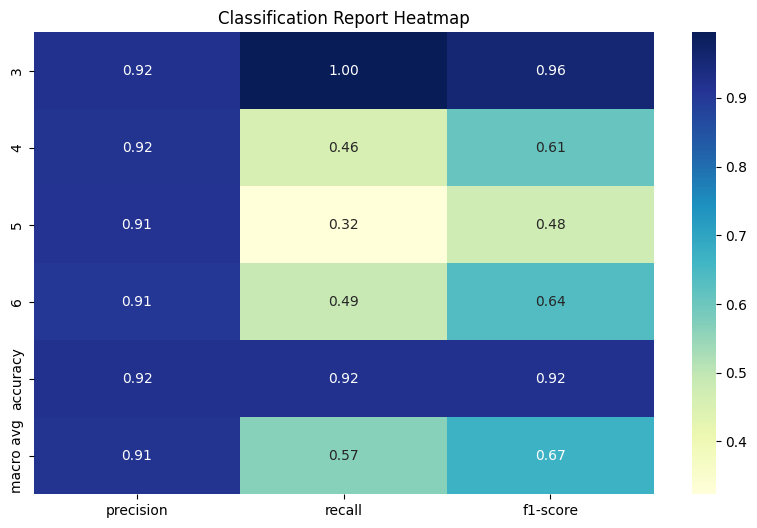

In [54]:
# Drop the 'support' column if you don't want to visualize it
# report_df.drop(columns='support', inplace=True)

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")  # Exclude the last row (avg/total)
plt.title('Classification Report Heatmap')
plt.show()


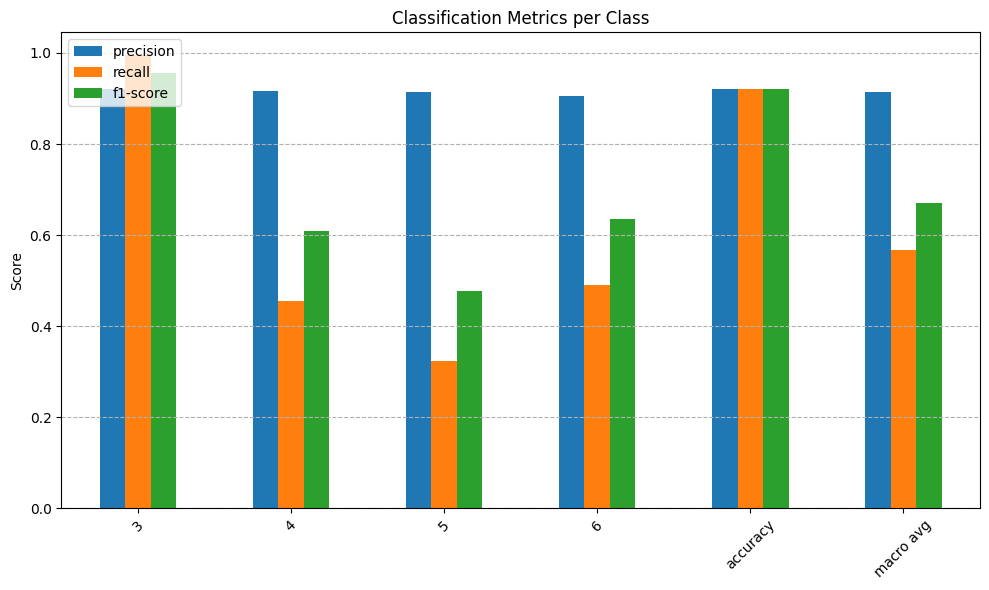

In [55]:
report_df.drop('support', axis=1, inplace=True)  # If not already done
report_df[:-1].plot(kind='bar', figsize=(10, 6))  # Exclude summary row
plt.title('Classification Metrics per Class')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()


In [56]:
# pred_input = dd.from_pandas(monthly_data_df_sample[num_cols], npartitions=X_train.npartitions)

In [57]:
y_pred_all = model.predict(ddf[num_cols])

In [58]:
y_pred_computed = le.inverse_transform(y_pred_all.compute())

# Convert the numpy array back into a Dask array
y_pred_dask_array = da.from_array(y_pred_computed, chunks=(1000))  # Adjust chunk size as appropriate

# Convert the Dask array into a Dask Series
y_pred_dask_series = dd.from_dask_array(y_pred_dask_array)

ddf['spei_prediction'] = y_pred_dask_series

/env/lib/python3.10/site-packages/distributed/client.py:3163: UserWarning: Sending large graph of size 197.26 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [45]:
ddf

,month_year,y,x,spei,spei_shifted,spei_classification,pr,pr_std,tmin,tmax,NVDI,spatial_ref,spei_prediction
npartitions=2687,,,,,,,,,,,,,
0,string,float64,float64,float32,float32,int64,float32,float32,float32,float32,float64,int32,float64
1000,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2958831,...,...,...,...,...,...,...,...,...,...,...,...,...
3287588,...,...,...,...,...,...,...,...,...,...,...,...,...


In [46]:
ddf

,month_year,y,x,spei,spei_shifted,spei_classification,pr,pr_std,tmin,tmax,NVDI,spatial_ref,spei_prediction
npartitions=2687,,,,,,,,,,,,,
0,string,float64,float64,float32,float32,int64,float32,float32,float32,float32,float64,int32,float64
1000,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2958831,...,...,...,...,...,...,...,...,...,...,...,...,...
3287588,...,...,...,...,...,...,...,...,...,...,...,...,...


In [47]:
X_test

,pr,pr_std,tmin,tmax,NVDI
npartitions=10,,,,,
0,float32,float32,float32,float32,float64
328759,...,...,...,...,...
...,...,...,...,...,...
2958831,...,...,...,...,...
3287588,...,...,...,...,...
